In [3]:
import json
import numpy as np
import pandas as pd
from skimage import io
from bigfish.detection import detect_spots
from bigfish.stack import remove_background_gaussian
# from bigfish.stack import get_in_focus_indices
from bigfish.stack import compute_focus
import bigfish.plot as plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from typing import Tuple
import logging
import os
import napari



In [4]:
def find_high_density_patch(mask: np.ndarray, patch_size: Tuple = (200, 200), attempts: int = 20):
    """

    randomly samples patches on the mask image and returns the coordinates of the top-left corner
    of the densest patch

    :param mask: segmentation image expected to have dimension (h * w)
    :param patch_size: height and width of the patch
    :param attempts: how many patches to try

    :return: coordinates of top left corner of densest patch found
    :rtype: Tuple[int, int]

    """
    h, w = mask.shape
    h_patch, w_patch = patch_size

    cell_pixels = 0
    selected_patch = (None, None)  # top left corner
    for attempt in range(attempts):

        row_sample = np.random.randint(0, h - h_patch)
        col_sample = np.random.randint(0, w - w_patch)

        sample_patch = mask[row_sample:row_sample + h_patch, col_sample:col_sample + w_patch]
        if np.sum(sample_patch > 0) > cell_pixels:
            cell_pixels = np.sum(sample_patch > 0)
            selected_patch = (row_sample, col_sample)

    return selected_patch


def find_in_focus_indices(focus: np.ndarray, adjustment_bottom: int = 5, adjustment_top: int = 10):
    """

    find the in-focus indices of calculated focus scores

    :param focus: series of values representing max intensity along z-axis
    :param adjustment_bottom: controls by how much the resulting range should be padded (bottom)
    :param adjustment_top: controls by how much the resulting range should be padded (top)

    :return: low and high z-level between which the spots are in focus
    :rtype: Tuple[int,int]
    """

    # find the inflection points of the smoothed curve
    ifx_1 = min([np.diff(focus).argmax(), np.diff(focus).argmin()])
    ifx_2 = max([np.diff(focus).argmax(), np.diff(focus).argmin()])

    # add a little cushion to one side.
    ifx_1 -= adjustment_bottom
    ifx_2 += adjustment_top

    print(adjustment_top, adjustment_bottom)
    return ifx_1, ifx_2

def show_boundaries(projected_focus, projected_focus_smoothed, ifx_1, ifx_2):
    # plotting of in-focus indices
    fig, axis = plt.subplots(ncols=3, figsize=(15, 5), facecolor='white')

    # plot max project focus scores
    sns.lineplot(x=range(len(projected_focus)), y=projected_focus, ax=axis[0])
    axis[0].set_xlabel('z-layer')
    axis[0].set_ylabel('score')
    axis[0].set_title('in-focus scores per z-layer')

    # plot smoothed focus scores
    sns.lineplot(x=range(len(projected_focus_smoothed)), y=projected_focus_smoothed, ax=axis[1])
    axis[1].set_xlabel('z-layer')
    axis[1].set_ylabel('score')
    axis[1].set_title('smoothed in-focus scores per z-layer')

    # plot projected focus image
    axis[2].imshow(np.amax(focus, axis=1))
    axis[2].set_title('y-max projection of the in-focus scores')

    # add indices of inflection point to plots
    axis[0].axvspan(ifx_1 - 0.1, ifx_1, color='r')
    axis[0].axvspan(ifx_2 - 0.1, ifx_2, color='r')

    axis[1].axvspan(ifx_1 - 0.1, ifx_1, color='r')
    axis[1].axvspan(ifx_2 - 0.1, ifx_2, color='r')

    axis[2].axhspan(ifx_1 - 0.1, ifx_1, color='r')
    axis[2].axhspan(ifx_2 - 0.1, ifx_2, color='r')

    return fig

In [5]:
configfile = '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/output-seg_ok/config.json'
with open(configfile, 'r') as f:
    config = json.load(f)

In [6]:
imgfile = '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/output-seg_ok/MG1655_GLU_OD_0.3_left_02/img.json'
with open(imgfile, 'r') as f:
    img = json.load(f)
img

{'sourcefile': '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/input-seg_ok/MG1655_GLU_OD_0.3_left_CY5, CY3.5 NAR, CY3, DAPI_02.vsi',
 'rootdir': '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/input-seg_ok',
 'basename': 'MG1655_GLU_OD_0.3_left_CY5, CY3.5 NAR, CY3, DAPI_02',
 'format': 'vsi',
 'time': {'01-configure': 6.465423107147217,
  '02-segment-DIC': 5.371973752975464,
  '02-segment-DAPI': 5.3546178340911865,
  '03-detect-spots': 87.33338117599487,
  '04-decompose-spots': 41.76766109466553,
  '05-assign-spots': 2.519124984741211},
 'stem': 'MG1655_GLU_OD_0.3_left_02',
 'seqnr': '02',
 'dicbasename': 'MG1655_GLU_OD_0.3_left_DIC_02.tif',
 'dicfile': '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/output-seg_ok/MG1655_GLU_OD_0.3_left_02/DIC.tif',
 'inputdicfile': '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/input-seg_ok/MG1655_GLU_OD_0.3_left_DIC_02.tif',
 'cellmaskfile': '/Users/adele/PycharmProjects/Ecoli_smFISH/tests/output-seg_ok/MG1655_GLU_OD_0.3_left_02/DIC_masks.tif',

In [7]:
# parameters - adjust if necessary
scale = (200, 65, 65)
spot_radius = (1250, 170, 170)
sigma = (0.75, 2.3, 2.3)
patch_size = (200, 200)
detection_threshold = None  # set to None for automatic determination by bigFISH
# detection threshold is usually optimised manually and might need to be set differently per channel

In [8]:
# load image data
mrna = 'rpoD'
mrna_data = io.imread(img[mrna]['rnafile'])
cell_mask_data = io.imread(img['cellmaskfile'])

/Users/adele/miniconda3/envs/ecoli/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


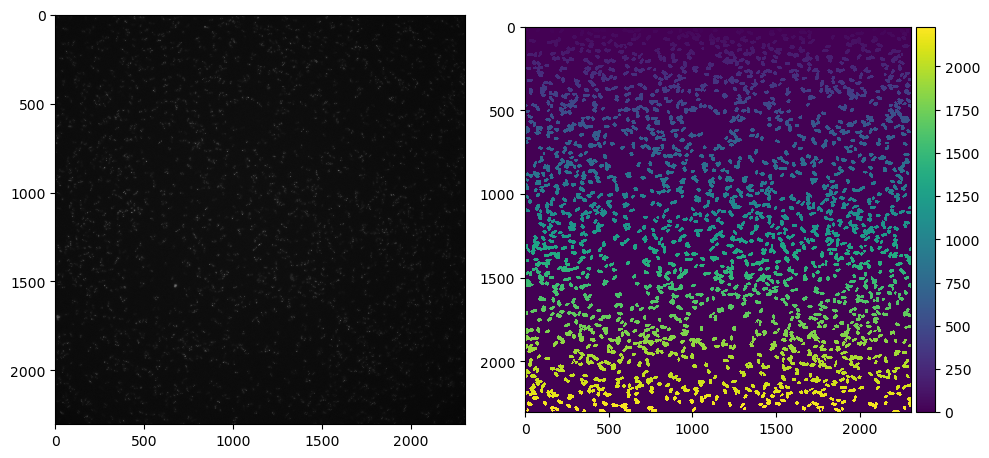

In [9]:
# inspect match
fig, ax = plt.subplots(ncols=2, figsize=(10, 5), facecolor='white')
io.imshow(mrna_data[17, ...], ax=ax[0]);
io.imshow(cell_mask_data, ax=ax[1]);
plt.show();

selected_patch: selected_patch=(291, 116)


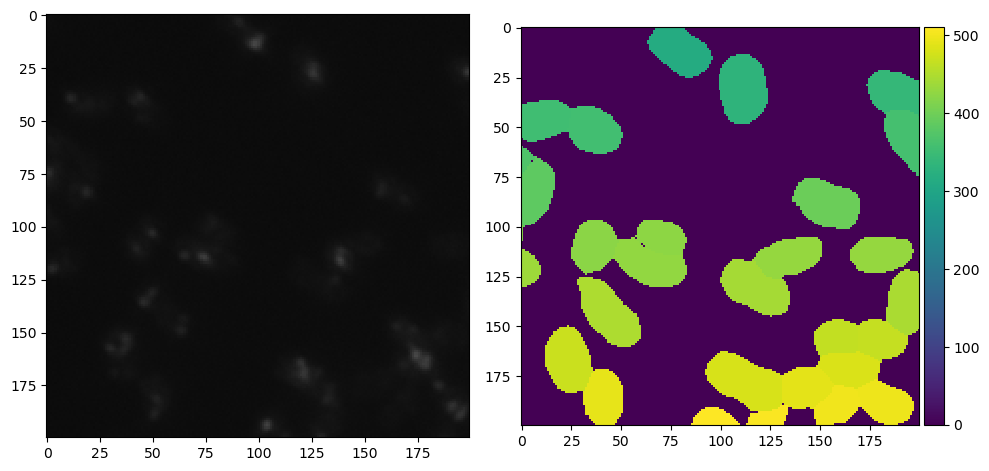

In [10]:
# find high density region
selected_patch = find_high_density_patch(cell_mask_data, patch_size=patch_size)
print(f"selected_patch: {selected_patch=}")

mask_patch = cell_mask_data[
             selected_patch[0]:selected_patch[0] + patch_size[0],
             selected_patch[1]:selected_patch[1] + patch_size[1]
             ]

img_patch = mrna_data[:,
            selected_patch[0]:selected_patch[0] + patch_size[0],
            selected_patch[1]:selected_patch[1] + patch_size[1]
            ]

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), facecolor='white')
io.imshow(img_patch[17, ...], ax=ax[0]);
io.imshow(mask_patch, ax=ax[1]);
plt.show();

/Users/adele/miniconda3/envs/ecoli/lib/python3.12/site-packages/skimage/io/_plugins/matplotlib_plugin.py:158: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


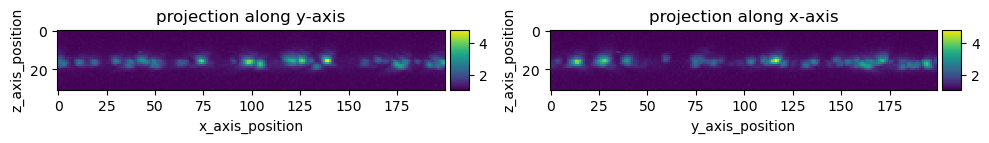

In [11]:
focus = compute_focus(img_patch)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5), facecolor='white')
io.imshow(np.amax(focus, axis=1), ax=ax[0])
io.imshow(np.amax(focus, axis=2), ax=ax[1])

ax[0].set_xlabel('x_axis_position')
ax[0].set_ylabel('z_axis_position')
ax[0].set_title('projection along y-axis')

ax[1].set_xlabel('y_axis_position')
ax[1].set_ylabel('z_axis_position')
ax[1].set_title('projection along x-axis')

plt.tight_layout()
plt.show()

In [13]:
projected_focus = np.max(focus, axis=(1, 2))
projected_focus_smoothed = savgol_filter(projected_focus, 15, 2, 0)
ifx_1, ifx_2 = find_in_focus_indices(projected_focus_smoothed, adjustment_bottom=0, adjustment_top=0)
ifx_1 = max(ifx_1, 0)
ifx_2 = min(ifx_2, mrna_data.shape[0])
img[mrna]["z_max_focus"] = int(np.argmax(projected_focus_smoothed))
img[mrna]["ifx_1"] = int(ifx_1)
img[mrna]["ifx_2"] = int(ifx_2) 

if ifx_1 < 0 or ifx_2 > mrna_data.shape[0]:
    print(f'....warning: max focus is too close to highest or lowest slice')
print(f'....in focus indices: [{ifx_1}, {ifx_2}] (max focus at slice {img[mrna]["z_max_focus"]})')

0 0
....in focus indices: [12, 20] (max focus at slice 16)


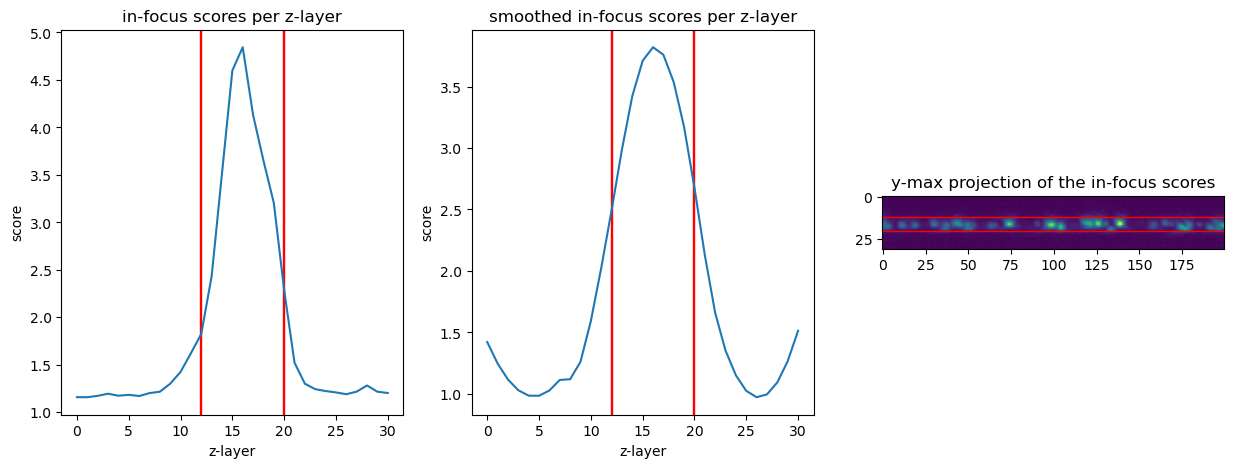

In [14]:
fig = show_boundaries(projected_focus, projected_focus_smoothed, ifx_1, ifx_2)
plt.show()

In [15]:
# perform background filtering on your image. Adjust filtering parameters if necessary
mrna_filtered = remove_background_gaussian(mrna_data, sigma=sigma)


In [ ]:
viewer = napari.Viewer()

In [ ]:
# here we add our image to the napari viewer, whilst also converting the pixel size to the nm scale
viewer.add_image(mrna_data, name='RNA channel', colormap='magenta', scale=scale)
viewer.add_image(mrna_filtered, name='filt RNA channel', scale=scale)

In [17]:
detection_threshold = None
mrna_filtered_selected = mrna_filtered[ifx_1:ifx_2, ...]
spots, threshold = detect_spots(
    mrna_filtered_selected,
    threshold=detection_threshold,
    voxel_size=scale,
    spot_radius=spot_radius,
    return_threshold=True
)

filtered_padded_intensities = np.concatenate((np.zeros([ifx_1, mrna_data.shape[1], mrna_data.shape[2]]), mrna_filtered_selected, np.zeros([mrna_data.shape[0]- ifx_2, mrna_data.shape[1], mrna_data.shape[2]])), axis=0)

# restore z-level
spots[:, 0] = spots[:, 0] + ifx_1

# adjustable out-of focus filtering
spots = spots[spots[:, 0] > ifx_1 + 0]
spot_intensities = np.resize(np.array([mrna_data[s[0], s[1], s[2]] for s in spots]), (len(spots), 1))
filtered_spot_intensities = np.resize(np.array([filtered_padded_intensities[s[0], s[1], s[2]] for s in spots]), (len(spots), 1))
spots_with_intensities = np.concatenate((spots, spot_intensities, filtered_spot_intensities), axis=1)

img[mrna]['spot_detection threshold'] = threshold
img[mrna]['number_of_spots'] = len(spots)
print(f'....spot detection threshold: {threshold}')
print(f'....number of spots found: {len(spots)}')
img[mrna]['spotsfile_latest'] = os.path.join(config['outputdir'], img['stem'], f'{mrna}_spots_thr={threshold}_ifx1={ifx_1}_ifx2={ifx_2}.npy')
np.save(img[mrna]['spotsfile_latest'], spots)


....spot detection threshold: 17.0
....number of spots found: 4666


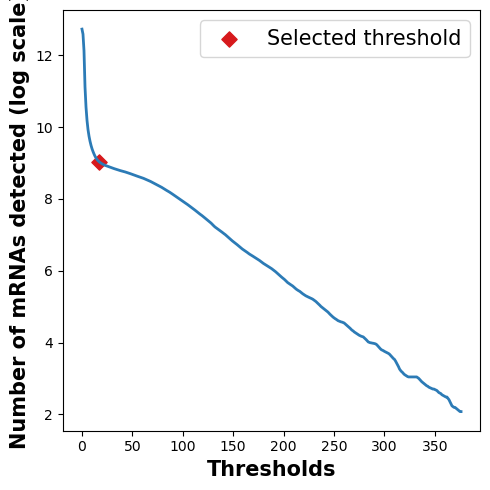

In [18]:
plot.plot_elbow(
    images=mrna_filtered[ifx_1:ifx_2, ...], 
    voxel_size=scale, 
    spot_radius=spot_radius)

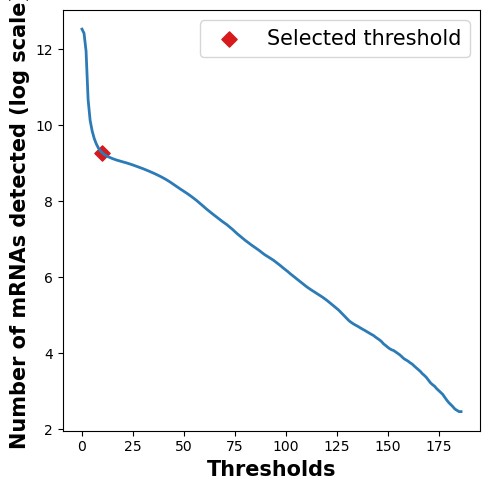

In [30]:
plot.plot_elbow(
    images=mrna_filtered, 
    voxel_size=scale, 
    spot_radius=spot_radius)

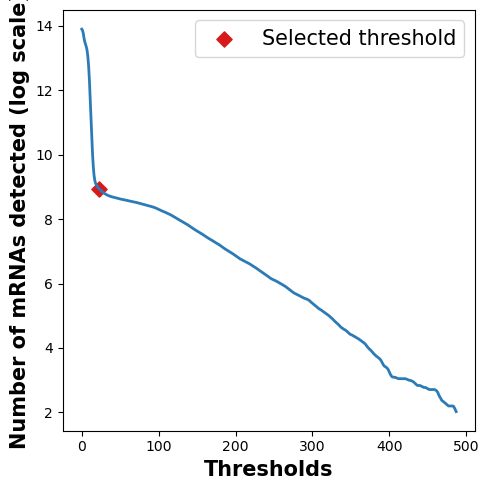

In [31]:
plot.plot_elbow(
    images=mrna_data, 
    voxel_size=scale, 
    spot_radius=spot_radius)

In [27]:
# Plot histogram of pixel value for pixels that lies within a selected spot
# This distribution should be very uniform (one sharp peak, or maybe two peaks if Tx's are visible)
spots = np.load('/Users/adele/PycharmProjects/Ecoli_smFISH/tests/output-seg_ok/MG1655_GLU_OD_0.3_left_02/rpoD_spots.npy')
df = pd.DataFrame(spots, columns=['z', 'y', 'x', 'intensity', 'filtered_intensity'])

df.sort_values(by=['z', 'y', 'x'], ascending=True, inplace=True)
df


,z,y,x,intensity,filtered_intensity
0,13.0,17.0,464.0,5732.0,690.0
7,13.0,85.0,50.0,8022.0,2006.0
1,13.0,165.0,237.0,7843.0,1853.0
3,13.0,255.0,200.0,4667.0,760.0
17,13.0,1016.0,109.0,4662.0,580.0
...,...,...,...,...,...
4765,20.0,2048.0,1628.0,13512.0,5334.0
4766,21.0,31.0,498.0,9991.0,3252.0
4763,21.0,1491.0,1424.0,10116.0,2036.0
4767,21.0,2043.0,1626.0,10995.0,3082.0


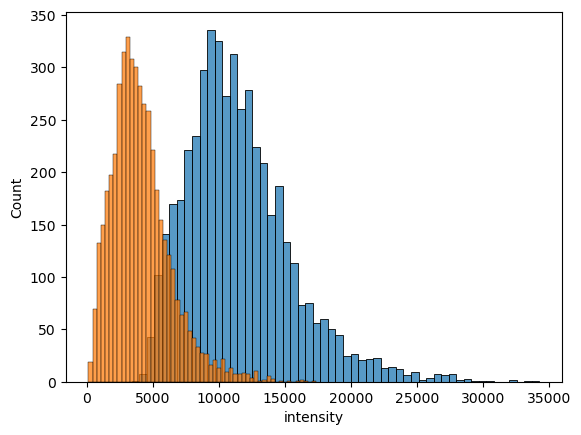

In [29]:
sns.histplot(df, x='intensity');
sns.histplot(df, x='filtered_intensity');

## Needs redoing after reprocessing data:

In [24]:
with open(configfile, 'r') as f:
    config_post = json.load(f)

In [25]:
df = pd.DataFrame()
for exp in config_post['experiments']:
    # print(f'{exp["strain"]}_{exp["condition"]}')
    for img in exp['images']:
        # print(f'{img["sourcefile"]}')
        for mrna in ['rpoD', 'rnlAB', 'hipBA']:
            # print(f'{mrna}')
            df = pd.concat([df, pd.DataFrame({
                'condition': exp['condition'],
                'img': img['stem'],
                'mrna': mrna,
                'ifx_1': img[mrna]['ifx_1'],
                'ifx_2': img[mrna]['ifx_2'],
                'focus': img[mrna]['z_max_focus'],
                'threshold': img[mrna]['spot_detection_threshold'],
                'nr_spots': img[mrna]['number_of_spots'],
            }, index=[0])])
            
            

conditions = [
    {'label': 'LB', 'mu': 2.3},
    {'label': 'GLU', 'mu': 0.54},
    {'label': 'GLY', 'mu': 0.32},
    {'label': 'GAL', 'mu': 0.17},
    {'label': 'MAN', 'mu': 0.12},
]
mrna_ordered = ['rpoD', 'hipBA', 'rnlAB']
csources_ordered = [c['label'] for c in conditions]
csources_ordered

def split_parts(s):
    parts = s. split('_')
    return parts[1][:3], parts[-1]

df[['csource', 'seqnr']] = df.apply(lambda r: split_parts(r['img']), axis=1, result_type='expand')
df = df[['csource', 'seqnr', 'mrna', 'ifx_1', 'ifx_2', 'focus', 'threshold', 'nr_spots']]
df

KeyError: 'spot_detection_threshold'

In [110]:
df.query('mrna == "hipBA"').sort_values(by=['csource', 'seqnr'])

,csource,seqnr,mrna,ifx_1,ifx_2,focus,threshold,nr_spots
0,GAL,01,hipBA,7,31,17,28.000000,157
0,GAL,05,hipBA,14,38,24,32.000000,71
0,GAL,06,hipBA,11,35,21,40.000000,38
0,GLU,01,hipBA,4,30,15,49.000000,192
0,GLU,02,hipBA,5,29,15,58.000000,92
0,GLU,03,hipBA,4,28,13,50.000000,139
0,GLY,08,hipBA,9,33,19,41.000000,87
0,GLY,16,hipBA,2,28,14,41.000000,59
0,GLY,17,hipBA,7,31,16,30.000000,130
0,LB,01,hipBA,12,35,22,23.000000,235


In [120]:
df.query('mrna == "rnlAB"').sort_values(by=['csource', 'seqnr'])

,csource,seqnr,mrna,ifx_1,ifx_2,focus,threshold,nr_spots
0,GAL,01,rnlAB,5,30,16,15.151515,299
0,GAL,05,rnlAB,16,40,26,24.363636,54
0,GAL,06,rnlAB,11,37,22,17.454545,197
0,GLU,01,rnlAB,8,31,18,8.272727,2056
0,GLU,02,rnlAB,5,29,15,9.333333,1647
0,GLU,03,rnlAB,4,28,14,21.555556,497
0,GLY,08,rnlAB,10,34,20,14.000000,333
0,GLY,16,rnlAB,4,29,14,21.000000,103
0,GLY,17,rnlAB,8,32,18,16.000000,220
0,LB,01,rnlAB,6,33,18,19.000000,2170


In [105]:
df.query('csource == "GLU"').query('seqnr == "02"')

,csource,seqnr,mrna,ifx_1,ifx_2,focus,threshold,nr_spots
0,GLU,02,rpoD,7,31,17,10.000000,4773
0,GLU,02,rnlAB,5,29,15,9.333333,1647
0,GLU,02,hipBA,5,29,15,58.000000,92


In [111]:
df.query('csource == "GLU"').query('seqnr == "01"')

,csource,seqnr,mrna,ifx_1,ifx_2,focus,threshold,nr_spots
0,GLU,01,rpoD,9,31,19,10.000000,5970
0,GLU,01,rnlAB,8,31,18,8.272727,2056
0,GLU,01,hipBA,4,30,15,49.000000,192


### Histogram of selected spots intensities